In [69]:
from simulate import simulate_convergence
import torch
from utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import gpytorch

In [70]:
# Make a small grid of uneven number (since we select central vector)
_, x = make_grid(n_side = 5)

# Squeeze and offset to center the grid
x = (x * 0.5) + 0.25
y = simulate_convergence(x)

# Check index of center value
x[24]

tensor([0.7500, 0.7500])

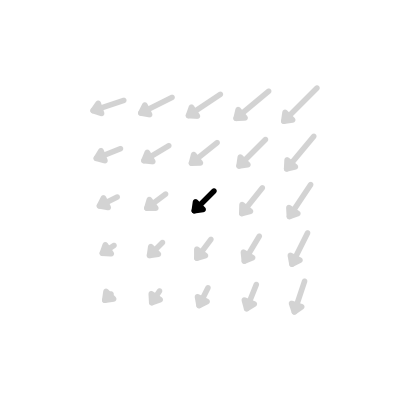

In [71]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import FancyArrowPatch

import numpy as np

# --- Generate data ---
_, x = make_grid(n_side = 5)
x = (x * 0.5) + 0.25  # Rescale to [0.25, 0.75]^2
y = simulate_convergence(x)
vecs = -y  # flip as in your original quiver plot

# --- Scale vectors ---
scale = 0.14  # Reduce arrow length
vecs = vecs * scale

# --- Centered line segments ---
starts = x - vecs / 2
ends = x + vecs / 2
segments = np.stack([starts, ends], axis = 1) 

# --- Plot ---
fig, ax = plt.subplots(figsize = (5, 5))

# Loop through all vectors and plot arrow patches
for i in range(len(x)):
    start = x[i] - vecs[i] / 2
    end = x[i] + vecs[i] / 2
    color = "black" if i == 12 else "lightgrey"
    arrow = FancyArrowPatch(
        posA = start, posB = end,
        arrowstyle='-|>, head_length = 0.4, head_width = 0.3',
        color = color,
        linewidth = 4,
        mutation_scale = 13,
    )
    ax.add_patch(arrow)

# Plot settings
ax.set_aspect('equal')
ax.axis('off')

plt.show()

# Sparse training data over Modis

In [72]:
modis_lower = torch.load("data/modis/modis_lower_byrd.pt", weights_only = False)
x_train_lower = torch.load("/home/kim/ice_thickness/data/real_data/region_lower_byrd_train_tensor.pt", weights_only = False)
print(modis_lower.shape)
print(x_train_lower.shape)

torch.Size([3, 240, 240])
torch.Size([12, 487])


In [73]:
ny, nx = modis_lower[2, :, :].shape
x_coords = np.linspace(0, 1, nx)
y_coords = np.linspace(0, 1, ny)
x_modis, y_modis = np.meshgrid(x_coords, y_coords)

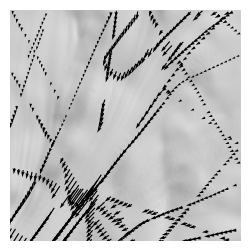

In [74]:
fig, ax = plt.subplots(figsize = (3, 3))  # set small figure size (in inches)

# Pcolor image
ax.pcolor(
    x_modis,
    y_modis,
    np.flipud(modis_lower[2, :, :].numpy()), # flip 
    cmap = 'gray', 
    vmin = 0, vmax = 20000, 
    shading='auto'
)

# Quivers
ax.quiver(
    x_train_lower[0, ::1], 
    x_train_lower[1, ::1], 
    x_train_lower[3, ::1], 
    x_train_lower[4, ::1], 
    color = "black",
    scale = 70, 
    width = 0.005,
    # alpha = 0.4
)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

plt.savefig(f"figures_real/train/lower_train_modis.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

# Posterior sample over Modis

In [75]:
mean = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_mean_predictions.pt", weights_only = False)

latent_covar = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_latent_covar_predictions.pt", weights_only = False)

covar = torch.load(
    "results_real/dfNGP_grid_inference/region_lower_byrd_dfNGP_grid_covar_predictions.pt", weights_only = False)

posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)

In [80]:
N = mean.shape[0]
N_side = int(np.sqrt(N))
_, x = make_grid(n_side = N_side)

# detach
mean = mean.detach().cpu()
covar = covar.detach().cpu()
sample = posterior.sample().detach().cpu()

# magnitude
sample_magnitude = sample.norm(dim = 1)

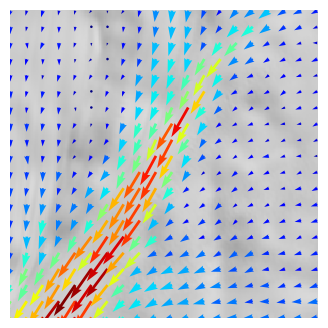

In [81]:
fig, ax = plt.subplots(figsize = (4, 4))  # set small figure size (in inches)

# Pcolor image
ax.pcolor(
    x_modis,
    y_modis,
    np.flipud(modis_lower[2, :, :].numpy()), # flip 
    cmap = 'gray', 
    vmin = 0, vmax = 20000, 
    shading='auto'
)

# Quivers
ax.quiver(
    x[::1, 0],
    x[::1, 1],
    sample[::1, 0], 
    sample[::1, 1], 
    sample_magnitude[::1],
    cmap = 'jet',
    scale = 60, 
    width = 0.009,
)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

plt.savefig(f"figures_real/train/lower_modis_sample.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

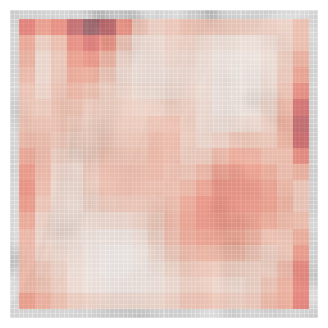

In [ ]:
half = int(covar.shape[0]/2)
var = torch.diag(covar).detach().cpu().reshape(half, 2)
var = var.sum(dim = -1)  # sum over tasks
var_2d = var.reshape(N_side, N_side)  # or however your grid is shaped
var_2d_cropped = var_2d[1:-1, 1:-1]  # crop to remove edges
var_2d_cropped_max = var_2d_cropped.max()

X = x[:, 0].reshape(N_side, N_side)
Y = x[:, 1].reshape(N_side, N_side)

X_cropped = X[1:-1, 1:-1]
Y_cropped = Y[1:-1, 1:-1]

fig, ax = plt.subplots(figsize = (4, 4))  # set small figure size (in inches)

# Pcolor image
ax.pcolor(
    x_modis,
    y_modis,
    np.flipud(modis_lower[2, :, :].numpy()), # flip 
    cmap = 'gray', 
    vmin = 0, vmax = 20000, 
    shading = 'auto',
    alpha = 0.4
)

var_2d = var.reshape(N_side, N_side)  # or however your grid is shaped

X = x[:, 0].reshape(N_side, N_side)
Y = x[:, 1].reshape(N_side, N_side)

ax.pcolormesh(
    X_cropped,
    Y_cropped,
    var_2d_cropped,
    cmap = 'Reds',
    alpha = 0.5, 
    vmax = var_2d_cropped_max,
)

# Optional aspect ratio
ax.set_aspect('equal')

# Turn off axes
ax.axis('off')

plt.savefig(f"figures_real/train/lower_modis_var.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

/tmp/ipykernel_1469781/287656844.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma')
/home/kim/anaconda3/envs/gpytorch-env/lib/python3.10/site-packages/numpy/ma/core.py:7165: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1e+20].


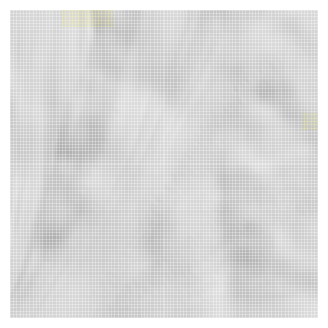

In [143]:
from matplotlib import cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(4, 4))

# Background
ax.pcolor(
    x_modis, y_modis,
    np.flipud(modis_lower[2, :, :].numpy()),
    cmap='gray', vmin=0, vmax=20000,
    shading='auto', alpha=0.4
)

# Normalize and color map
norm = Normalize(vmin=0, vmax=np.percentile(var_2d_cropped, 99))
cmap = cm.get_cmap('magma')
rgba = cmap(norm(var_2d_cropped))
rgba[..., 3] = norm(var_2d_cropped)**1000000  # adjust exponent for more contrast

# Overlay variance as pigmented alpha
ax.imshow(
    rgba,
    origin='lower',
    extent=[X_cropped.min(), X_cropped.max(), Y_cropped.min(), Y_cropped.max()],
    interpolation='none'
)

ax.set_aspect('equal')
ax.axis('off')

plt.savefig("figures_real/train/lower_modis_var_alpha.png", dpi=300, bbox_inches='tight', pad_inches=0)